# Burn mapping validation
This Notebook  shows the workflow of roc (Receiver operating characteristic) analysis of burn mapping with fire perimeters polygons

## import the required modules 
import the validationtoolbox for validation

In [5]:
import xarray as xr
import numpy as np
import validationtoolbox
import matplotlib.pyplot as plt
%matplotlib inline

## load the severity map
load a saved netcdf file for the severity for central plateau in 2016 for validation 

the severity mapping steps can also be inserted here 

In [18]:
sev = xr.open_dataset('Sumac_Forest_TAS_2015-07-01_2016-06-30_severity.nc')

## conver the severity to a burned/burned mask for validation
use the burnpixel_masking from the validation toolbox

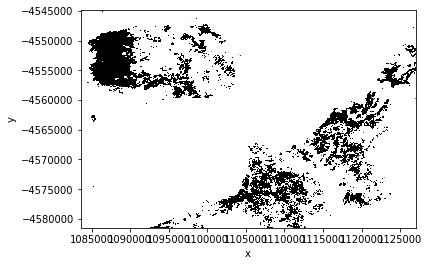

In [19]:
Burnpixel = validationtoolbox.burnpixel_masking(sev)
Burnpixel.plot.imshow(cmap='binary',add_colorbar=False)

## seperate the burned area into forest burned and none forest burned area
use the "treecover_masking" tool to generate the tree cover mask for the given region.

Required inputs:

    "year" should be before the bushfire, 
    "data" the Burnpixel with x,y
    "prctg" the treecover fraction used for forest mapping, default is 60
Outputs:

    forest mask, 1 for forest 0 for none forest
    none-forest mask, 1 for none-forest mask 0 for forest
    

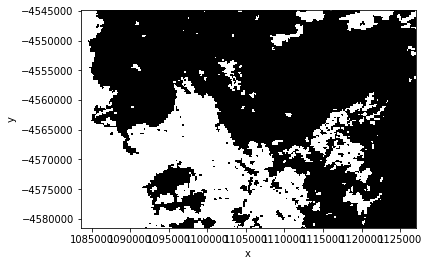

In [20]:
mask=validationtoolbox.treecover_masking(year=2015,data=Burnpixel,prctg=60)
mask.ForestMask.plot.imshow(cmap='binary',add_colorbar=False)

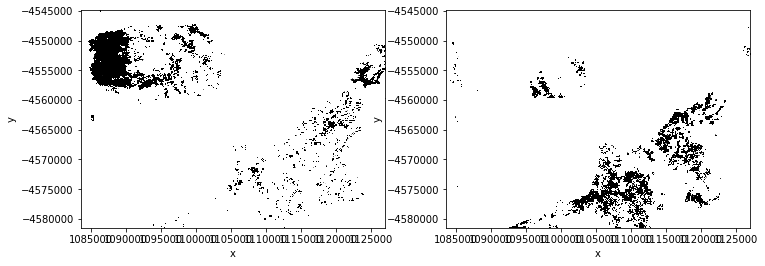

In [21]:
ForestBurned = Burnpixel*mask.ForestMask # burned pixel found in the forest area
NoneForestBurned = Burnpixel*mask.NoneForestMask # burned pixel found in the non-forest area
fig,axes=plt.subplots(ncols=2,figsize=[12,4])
ForestBurned.plot.imshow(ax=axes[0],cmap='binary',add_colorbar=False)
NoneForestBurned.plot.imshow(ax=axes[1],cmap='binary',add_colorbar=False)

## generate validation mask for roc analysis
use "CreateValidatedBurnMask" for creating corresponding validation mask from the shapefiles of fire perimeters polygons

required inputs:

    BurnPixel: burned pixel 
    State: abbrev of the state name 
    Validation_period: start and end
    
output mask includes the mask at each time step, sum up if a single mask required


In [22]:
ValidationMask=validationtoolbox.CreateValidatedBurnMask(Burnpixel,State='TAS', Validation_period=("2016-01-01","2016-12-31"))
ValidationMask = ValidationMask.sum('time') #create one mask with all the burned area

I am densified (external_values, 8752 elements)


Text(0.5,1,'validation mask for the burned forest area')

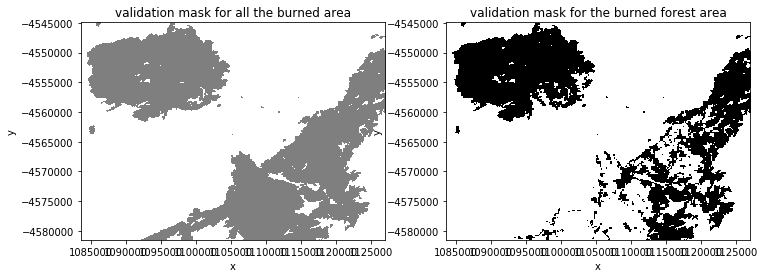

In [23]:
fig,axes=plt.subplots(ncols=2,figsize=[12,4])
ValidationMask.plot.imshow(ax=axes[0],cmap='binary',add_colorbar=False) # validation mask for all the burned area
axes[0].set_title('validation mask for all the burned area')
forestvalmask = ValidationMask*mask.ForestMask
forestvalmask.plot.imshow(ax=axes[1],cmap='binary',add_colorbar=False) # validation mask for all the burned forest area
axes[1].set_title('validation mask for the burned forest area')

## validate forest burned pixel with forest burned
roc analysis for the burned forest area use "validate" module

[8.5703756395642819e-06, 0.24113559281834784]

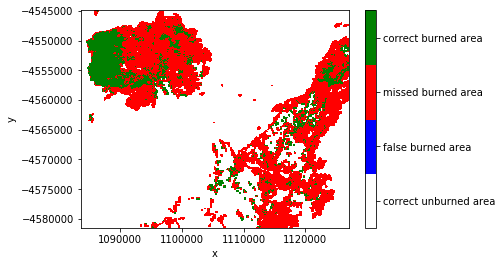

In [24]:
validationtoolbox.validate(Test_Array=ForestBurned,Validated_Array=forestvalmask, plot=True)

[6.3395907441975131e-05, 0.52112091948575157]

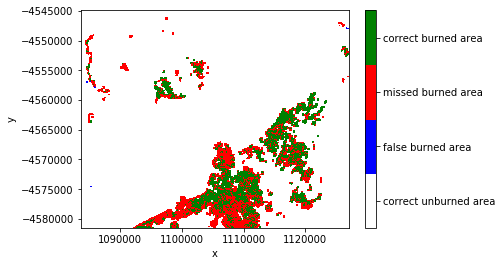

In [25]:
validationtoolbox.validate(Test_Array=NoneForestBurned,Validated_Array=ValidationMask*mask.NoneForestMask, plot=True)